# Napari Python Application for Westmeyer Lab
Run the Imports and Napari Window to open Napari Viewer. 

# Imports and Napari Window

### Imports

In [2]:
import napari
from magicgui import magic_factory
from skimage import data
from skimage.util import img_as_float
from magicgui import magicgui
from pathlib import Path
import os
import shutil
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.measure import regionprops
from skimage import exposure, morphology, measure
import plotly.graph_objs as go
from plotly.io import to_html
#viewer = napari.view_image(nuclei, colormap='magma')

### Functions and Napari Window

In [3]:
@magic_factory(input_directory={'label': 'Write directory to merge images'}) #(merge_images={"widget_type": "FloatSlider", "max": 1}, auto_call=True)
def merge(input_directory: str) -> None: #'napari.types.LabelsData'
    merge.native.setWindowTitle("Merge Images")
    image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.TIF')]

    if not image_paths:
        print("No .tif files found in the directory.")
        return
    
    image_paths.sort()  # Sort the image paths in ascending order
    images = [Image.open(path) for path in image_paths]
    filename = os.path.join(input_directory, 'MergedImages.tif')
    images[0].save(filename, save_all=True, append_images=images[1:])
    print("Images merged successfully!")

@magic_factory(src_folder={'label': 'Paste the path to move images'})
def move(src_folder: str, No_of_Channels: int) -> None:
    # Create the parent directory for channels
    parent_folder = os.path.join(src_folder, 'Chnls')
    os.makedirs(parent_folder, exist_ok=True)
    
    # Create destination folders in the parent folder
    dest_folders = [os.path.join(parent_folder, f"Ch{i+1}") for i in range(No_of_Channels)]

    # Make sure each destination folder exists
    for folder in dest_folders:
        os.makedirs(folder, exist_ok=True)
    
    # Get a list of all files in the source folder and sort them alphabetically
    files = sorted(os.listdir(src_folder))
    
    # Move images to the destination folders
    for i, filename in enumerate(files):
        src_path = os.path.join(src_folder, filename)

        # Ensure we only move files, not directories, and skip hidden files
        if os.path.isfile(src_path) and not filename.startswith('.'):
            dest_folder = dest_folders[i % No_of_Channels]
            dest_path = os.path.join(dest_folder, filename)
            
            try:
                shutil.move(src_path, dest_path)
                print(f"Moved {filename} to {dest_path}")
            except Exception as e:
                print(f"Error moving {filename} to {dest_path}: {e}")
        else:
            print(f"Skipping {filename}, not a file or hidden.")

@magic_factory(layer={"label": "Select Layer to turn into numpy array"})
def get_layer_as_array(viewer: 'napari.Viewer', layer: 'napari.layers.Layer') -> np.ndarray:
    if layer is None:
        print("No layer selected.")
        return

    # Get the data from the selected layer
    data = layer.data
    
    # Convert the data to a numpy array
    deneme = np.array(data)
    
    # Add the image to the viewer (optional)
    viewer.add_image(deneme, name=f"Numpy array {layer.name}")

@magic_factory(
    image_layer={"label": "Select Image Layer"},
    histogram_equalization={"widget_type": "Checkbox", "text": "Hist. Eq. (CLAHE)"},
    clip_limit={"widget_type": "FloatSlider", "max": 40, "min": 1, "step": 0.5, "label": "CLAHE Clip Limit"},
    normalization={"widget_type": "Checkbox", "text": "Normalization"},
    resize_to_512_512={"widget_type": "Checkbox", "text": "Resize to 512x512"},
    denoising={"widget_type": "Checkbox", "text": "Denoising"},
    h_value={"widget_type": "Slider", "max": 100, "min": 0, "step": 1, "label": "Denoising Strength (h value)"}
)
def preprocess_image(
    viewer: 'napari.Viewer', 
    image_layer: 'napari.layers.Image', 
    histogram_equalization: bool = False, 
    clip_limit: float = 5.0,
    normalization: bool = False, 
    resize_to_512_512: bool = False, 
    denoising: bool = False, 
    h_value: int = 40
) -> np.ndarray:
    
    if image_layer is None:
        print("No image layer selected.")
        return

    img_stack = image_layer.data
    processed_stack = []

    preprocessing_selected = histogram_equalization or normalization or resize_to_512_512 or denoising

    if not preprocessing_selected:
        print("No preprocessing selected.")
        return

    for img in img_stack:
        processed_image = img.copy()  # Make a copy of the original image

        if histogram_equalization:
            clahe = cv2.createCLAHE(clipLimit=clip_limit)
            processed_image = clahe.apply(processed_image)

        if normalization:
            processed_image = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image))
        
        # Ensure the processed image is in float32 format for OpenCV operations
        #processed_image = (processed_image * 255).astype(np.float32)

        if resize_to_512_512:
            processed_image = cv2.resize(processed_image, (512, 512))

        if denoising:
            processed_image = processed_image.astype(np.uint8)
            processed_image = cv2.fastNlMeansDenoising(processed_image, None, h=h_value)

        # Ensure the final image is in uint8 format for display
        #processed_image = processed_image.astype(np.uint8)
        processed_stack.append(processed_image)

    processed_stack = np.array(processed_stack)


    # Add the processed image stack as a new layer in the napari viewer
    viewer.add_image(processed_stack, name="Processed Image")

@magic_factory(layer={"label": "Select Layer to take image from"})
def select_image(layer: napari.layers.Image,image_index: int) -> None:
    """Select and display a single image from the stack."""
    if layer is None:
        print("No layer selected.")
        return
    img_stack = layer.data
    if image_index < 0 or image_index >= img_stack.shape[0]:
        print("Index out of range.")
        return
    single_image = img_stack[image_index]
    viewer.add_image(single_image, name='Selected Single Image')

###########################

@magic_factory(
    image_stack={'label': 'Select Image Stack Layer'},
    mask_layer={'label': 'Select Mask Layer'}
)
def plot_fluorescence(
    image_stack: 'napari.layers.Image',
    mask_layer: 'napari.layers.Labels'
) -> None:
    
    # Ensure the layers are selected
    if image_stack is None or mask_layer is None:
        print("No image stack or mask layer selected.")
        return

    # Get the data from the selected layers
    image_stack_data = image_stack.data
    mask_data = mask_layer.data

    # Collect fluorescence data for each cell
    cell_fluorescence = {}
    
    # Process the image stack
    if len(image_stack_data.shape) == 4:
        # 4D stack (n, c, h, w)
        for cell_id in np.unique(mask_data):
            if cell_id == 0:  # Skip background
                continue
            cell_mask = mask_data == cell_id
            cell_fluorescence[cell_id] = [
                frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
            ]
        
    elif len(image_stack_data.shape) == 3:
        # 3D stack (c, h, w)
        for cell_id in np.unique(mask_data):
            if cell_id == 0:  # Skip background
                continue
            cell_mask = mask_data == cell_id
            cell_fluorescence[cell_id] = [
                frame[cell_mask].mean() for frame in image_stack_data
            ]
    # Plotting fluorescence data for each cell using Plotly
    fig = go.Figure()
    
    for cell_id, fluorescence in cell_fluorescence.items():
        fig.add_trace(go.Scatter(
            x=list(range(len(fluorescence))), 
            y=fluorescence, 
            mode='lines', 
            name=f'Cell {cell_id}'
        ))
    
    # Update layout
    fig.update_layout(
        title='Fluorescence Intensity of Cells Over Time',
        xaxis_title='Time (Frames)',
        yaxis_title='Fluorescence Intensity',
        xaxis=dict(zeroline=True),
        yaxis=dict(zeroline=True)
    )

    # Show plot
    fig.show()

@magic_factory(cellid={'label': 'Select Cell ID Number'}, mask_layer={'label': 'Select Mask Layer'})
def highlight(cellid: int, mask_layer: 'napari.layers.Labels') -> "napari.types.LabelsData":
    roi = mask_layer.data == cellid
    viewer.add_labels(roi, name=f'label_{cellid}')

###########################

my_widget1 = merge()
my_widget2 = move()
my_widget3 = get_layer_as_array()
my_widget4 = preprocess_image()
my_widget5 = select_image()
my_widget6 = plot_fluorescence()
my_widget7 = highlight()
viewer = napari.Viewer()
viewer.window.add_dock_widget(my_widget1)
viewer.window.add_dock_widget(my_widget2)
viewer.window.add_dock_widget(my_widget3)
viewer.window.add_dock_widget(my_widget4)
viewer.window.add_dock_widget(my_widget5)
viewer.window.add_dock_widget(my_widget6)
viewer.window.add_dock_widget(my_widget7)

# Template Code if Necessary

#### Print all layers in Viewer and load their data

In [4]:
print(viewer.layers)

[<Image layer 'Processed Image' at 0x325998fe0>, <Labels layer 'Selected Single Image_cp_masks_000' at 0x30af34080>]


In [5]:
img = viewer.layers[0]
imgdata = img.data
mask = viewer.layers[1]
maskdata = mask.data
print(np.shape(imgdata))
print(np.shape(maskdata))
#deneme= np.array(data)
#viewer.add_image(deneme)

(46, 1104, 1104)
(1104, 1104)


#### How to Create Fluorescence Plots

In [24]:
image_stack = img
mask_layer = mask

# Get the data from the selected layers
image_stack_data = image_stack.data
mask_data = mask_layer.data

# Collect fluorescence data for each cell
cell_fluorescence = {}

# Process the image stack
if len(image_stack_data.shape) == 4:
    # 4D stack (n, c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
        ]
    
elif len(image_stack_data.shape) == 3:
    # 3D stack (c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data
        ]
print('we are here')
# Plotting fluorescence data for each cell using Plotly
fig = go.Figure()

for cell_id, fluorescence in cell_fluorescence.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(fluorescence))), 
        y=fluorescence, 
        mode='lines', 
        name=f'Cell {cell_id}'
    ))

# Update layout
fig.update_layout(
    title='Fluorescence Intensity of Cells Over Time',
    xaxis_title='Time (Frames)',
    yaxis_title='Fluorescence Intensity',
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True)
)

# Show plot
fig.show()



we are here


/opt/homebrew/Caskroom/miniforge/base/envs/napari-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/opt/homebrew/Caskroom/miniforge/base/envs/napari-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



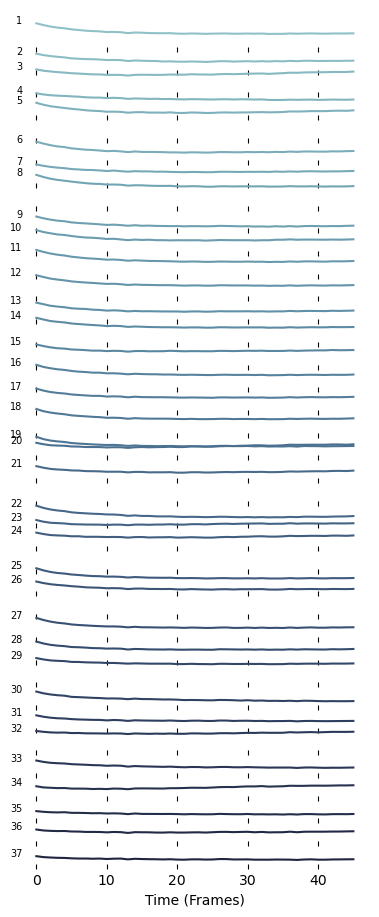

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data, replace with actual data
image_stack = img
mask_layer = mask

# Get the data from the selected layers
image_stack_data = image_stack.data
mask_data = mask_layer.data

# Collect fluorescence data for each cell
cell_fluorescence = {}

# Process the image stack
if len(image_stack_data.shape) == 4:
    # 4D stack (n, c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
        ]
    
elif len(image_stack_data.shape) == 3:
    # 3D stack (c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data
        ]

# Convert cell_fluorescence to a DataFrame for seaborn plotting
data = []
for cell_id, fluorescence in cell_fluorescence.items():
    for frame, intensity in enumerate(fluorescence):
        data.append([cell_id, frame, intensity])
df = pd.DataFrame(data, columns=['Cell ID', 'Time (Frames)', 'Fluorescence Intensity'])

# Initialize the FacetGrid object
num_cells = df['Cell ID'].nunique()
pal = sns.cubehelix_palette(num_cells, rot=-.25, light=.7)

# Create the FacetGrid with a reduced height for tighter subplots
g = sns.FacetGrid(df, row="Cell ID", hue="Cell ID", aspect=15, height=.3, palette=pal)

# Plot the fluorescence over time
g.map(sns.lineplot, "Time (Frames)", "Fluorescence Intensity", alpha=1, linewidth=1.5)

# Remove background color
for ax in g.axes.flat:
    ax.set_facecolor((0, 0, 0, 0))  # Set the facecolor to be fully transparent

# Define and use a function to label the plot in axes coordinates with arrows
def label(ax, cell_id):
    # Get the data for the cell
    cell_data = df[df['Cell ID'] == cell_id]
    x = cell_data['Time (Frames)'].iloc[0]
    y = cell_data['Fluorescence Intensity'].max()  # Use max Y value for positioning
    
    
    # Add the label with an arrow pointing to the plot line
    ax.annotate(f'{cell_id}', 
                xy=(x, y), 
                xytext=(x-2, y),
                fontsize=7, color='black', ha='right')

# Apply labels with arrows
for ax in g.axes.flat:
    cell_id = int(ax.get_title().split('=')[1])  # Extract cell ID from title
    label(ax, cell_id)

# Set the subplots to overlap more closely
g.figure.subplots_adjust(hspace=-0.4)  # Further adjusted for closer subplots

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show plot
plt.show()


#### Dock / Define again widget if necessary

In [3]:
my_widget7 = highlight()
viewer.window.add_dock_widget(my_widget7)

#### How to add image to Viewer

In [6]:
viewer.add_image(image) 

<Image layer 'first_image' at 0x325000a40>

#### Test Cellpose

In [ ]:
from cellpose import models, io
import numpy as np

# Initialize Cellpose model (use CPU to avoid GPU issues)
model = models.Cellpose(gpu=False)

# Run Cellpose model on the image
masks, flows, styles, diams = model.eval(first_image, diameter=None, channels=[0, 0])

print("Cellpose processing completed.")

#### Template Widget

In [ ]:
'''
@magicgui(
    threshold={"widget_type": "FloatSlider", "max": 1}, auto_call=True
)
def threshold_magic_widget(
    img_layer: "napari.layers.Image", threshold: "float"
) -> "napari.types.LabelsData":
    return img_as_float(img_layer.data) > threshold

# Create the viewer and add an image
viewer = napari.view_image(data.camera())
# Add widget to viewer
viewer.window.add_dock_widget(threshold_magic_widget)
'''